# Fashion Trend Analyser — Fashion-MNIST
This notebook trains a CNN to classify Fashion-MNIST items and demonstrates step-by-step data prep, training, evaluation, explainability (Grad-CAM), and saving/inference.

Run cells in order. Uses TensorFlow/Keras. You can either download Fashion-MNIST from Kaggle (optional) or use the built-in `tf.keras.datasets.fashion_mnist` for convenience.


In [1]:
# Runtime & GPU check
import sys, os
import tensorflow as tf
print("Python:", sys.version)
print("TF:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TF: 2.19.0
GPU available: []


In [2]:
# (Optional) Install Kaggle and mount Drive
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# (Optional) Upload kaggle.json & download dataset
from google.colab import files
print("Upload your kaggle.json now (from https://www.kaggle.com/account) — don't share it publicly.")
uploaded = files.upload()  # choose kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d zalando-research/fashionmnist -p /content --unzip


Upload your kaggle.json now (from https://www.kaggle.com/account) — don't share it publicly.


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.01GB/s]


In [4]:
# Install / update libs (if needed)
!pip install -q matplotlib seaborn scikit-learn opencv-python


In [5]:
# Imports & seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


In [6]:
# Load dataset (Keras built-in)
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Train:", x_train.shape, y_train.shape, "Test:", x_test.shape, y_test.shape)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.12, random_state=SEED, stratify=y_train)

print("Train:", x_train.shape, "Val:", x_val.shape, "Test:", x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (60000, 28, 28) (60000,) Test: (10000, 28, 28) (10000,)
Train: (52800, 28, 28) Val: (7200, 28, 28) Test: (10000, 28, 28)


,class,label,count
0,0,T-shirt/top,5280
1,1,Trouser,5280
2,2,Pullover,5280
3,3,Dress,5280
4,4,Coat,5280
5,5,Sandal,5280
6,6,Shirt,5280
7,7,Sneaker,5280
8,8,Bag,5280
9,9,Ankle boot,5280


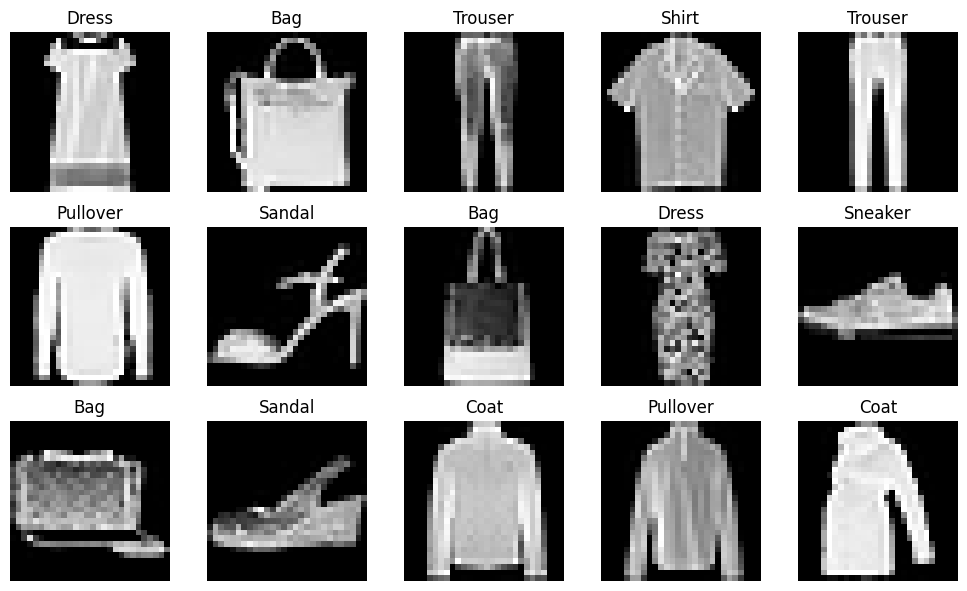

In [7]:
# Quick EDA (visualize samples & class distribution)
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

plt.figure(figsize=(10,6))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()

unique, counts = np.unique(y_train, return_counts=True)
import pandas as pd
display(pd.DataFrame({'class':unique, 'label': [class_names[i] for i in unique], 'count':counts}))


In [8]:
# Preprocessing pipeline (scaling + reshape)
x_train = x_train.astype('float32') / 255.0
x_val   = x_val.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, -1)
x_val   = np.expand_dims(x_val, -1)
x_test  = np.expand_dims(x_test, -1)

print('Shapes ->', x_train.shape, x_val.shape, x_test.shape)


Shapes -> (52800, 28, 28, 1) (7200, 28, 28, 1) (10000, 28, 28, 1)


In [9]:
# Data augmentation (ImageDataGenerator)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 64
train_gen = train_datagen.flow(x_train, keras.utils.to_categorical(y_train), batch_size=batch_size, shuffle=True, seed=SEED)
val_gen = ImageDataGenerator().flow(x_val, keras.utils.to_categorical(y_val), batch_size=batch_size, shuffle=False)


In [10]:
# Build CNN model
def make_model(input_shape=(28,28,1), n_classes=10):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model

model = make_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,882 (296.41 KB)

 Trainable params: 75,242 (293.91 KB)

 Non-trainable params: 640 (2.50 KB)

In [11]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
# Callbacks (checkpoint, early stopping, LR reduce)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

output_dir = "/content/drive/MyDrive/fashion_model"  # change if you want
os.makedirs(output_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(output_dir, "best_model.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
csvlog = CSVLogger(os.path.join(output_dir, "training_log.csv"))


In [13]:
# Train model
epochs = 30

history = model.fit(
    train_gen,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=val_gen,
    validation_steps=len(x_val) // batch_size,
    epochs=epochs,
    callbacks=[checkpoint, earlystop, reduce_lr, csvlog]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.6215 - loss: 1.0716
Epoch 1: val_accuracy improved from -inf to 0.82157, saving model to /content/drive/MyDrive/fashion_model/best_model.h5


825/825 ━━━━━━━━━━━━━━━━━━━━ 312s 372ms/step - accuracy: 0.6216 - loss: 1.0713 - val_accuracy: 0.8216 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 2/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8019 - loss: 0.5441
Epoch 2: val_accuracy improved from 0.82157 to 0.85296, saving model to /content/drive/MyDrive/fashion_model/best_model.h5


825/825 ━━━━━━━━━━━━━━━━━━━━ 323s 391ms/step - accuracy: 0.8019 - loss: 0.5441 - val_accuracy: 0.8530 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 3/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8329 - loss: 0.4605
Epoch 3: val_accuracy did not improve from 0.85296
825/825 ━━━━━━━━━━━━━━━━━━━━ 320s 388ms/step - accuracy: 0.8329 - loss: 0.4605 - val_accuracy: 0.8320 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 4/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8464 - loss: 0.4220
Epoch 4: val_accuracy improved from 0.85296 to 0.87207, saving model to /content/drive/MyDrive/fashion_model/best_model.h5


825/825 ━━━━━━━━━━━━━━━━━━━━ 306s 370ms/step - accuracy: 0.8464 - loss: 0.4220 - val_accuracy: 0.8721 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 5/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8535 - loss: 0.3997
Epoch 5: val_accuracy improved from 0.87207 to 0.89286, saving model to /content/drive/MyDrive/fashion_model/best_model.h5


825/825 ━━━━━━━━━━━━━━━━━━━━ 322s 390ms/step - accuracy: 0.8535 - loss: 0.3997 - val_accuracy: 0.8929 - val_loss: 0.2854 - learning_rate: 0.0010
Epoch 6/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8640 - loss: 0.3721
Epoch 6: val_accuracy did not improve from 0.89286
825/825 ━━━━━━━━━━━━━━━━━━━━ 304s 368ms/step - accuracy: 0.8640 - loss: 0.3721 - val_accuracy: 0.8617 - val_loss: 0.3522 - learning_rate: 0.0010
Epoch 7/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8708 - loss: 0.3603
Epoch 7: val_accuracy improved from 0.89286 to 0.90625, saving model to /content/drive/MyDrive/fashion_model/best_model.h5


825/825 ━━━━━━━━━━━━━━━━━━━━ 321s 367ms/step - accuracy: 0.8708 - loss: 0.3603 - val_accuracy: 0.9062 - val_loss: 0.2670 - learning_rate: 0.0010
Epoch 8/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8751 - loss: 0.3468
Epoch 8: val_accuracy did not improve from 0.90625
825/825 ━━━━━━━━━━━━━━━━━━━━ 300s 364ms/step - accuracy: 0.8751 - loss: 0.3468 - val_accuracy: 0.9043 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 9/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8767 - loss: 0.3424
Epoch 9: val_accuracy did not improve from 0.90625
825/825 ━━━━━━━━━━━━━━━━━━━━ 381s 436ms/step - accuracy: 0.8767 - loss: 0.3424 - val_accuracy: 0.8976 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 10/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8818 - loss: 0.3286
Epoch 10: val_accuracy did not improve from 0.90625
825/825 ━━━━━━━━━━━━━━━━━━━━ 306s 372ms/step - accuracy: 0.8818 - loss: 0.3286 - val_accuracy: 0.9005 - val_loss: 0.2684 - learning_rate: 0.0010
E

825/825 ━━━━━━━━━━━━━━━━━━━━ 323s 392ms/step - accuracy: 0.8878 - loss: 0.3108 - val_accuracy: 0.9199 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 16/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8911 - loss: 0.3020
Epoch 16: val_accuracy did not improve from 0.91992
825/825 ━━━━━━━━━━━━━━━━━━━━ 321s 389ms/step - accuracy: 0.8911 - loss: 0.3020 - val_accuracy: 0.9029 - val_loss: 0.2676 - learning_rate: 0.0010
Epoch 17/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8938 - loss: 0.2984
Epoch 17: val_accuracy did not improve from 0.91992
825/825 ━━━━━━━━━━━━━━━━━━━━ 322s 390ms/step - accuracy: 0.8938 - loss: 0.2984 - val_accuracy: 0.9132 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 18/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8964 - loss: 0.2885
Epoch 18: val_accuracy did not improve from 0.91992
825/825 ━━━━━━━━━━━━━━━━━━━━ 307s 372ms/step - accuracy: 0.8964 - loss: 0.2885 - val_accuracy: 0.9118 - val_loss: 0.2394 - learning_rate: 0.00

825/825 ━━━━━━━━━━━━━━━━━━━━ 323s 374ms/step - accuracy: 0.8984 - loss: 0.2787 - val_accuracy: 0.9280 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 24/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9002 - loss: 0.2741
Epoch 24: val_accuracy did not improve from 0.92801
825/825 ━━━━━━━━━━━━━━━━━━━━ 321s 389ms/step - accuracy: 0.9002 - loss: 0.2741 - val_accuracy: 0.9132 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 25/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9015 - loss: 0.2718
Epoch 25: val_accuracy did not improve from 0.92801
825/825 ━━━━━━━━━━━━━━━━━━━━ 321s 389ms/step - accuracy: 0.9015 - loss: 0.2718 - val_accuracy: 0.9188 - val_loss: 0.2368 - learning_rate: 0.0010
Epoch 26/30
825/825 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9012 - loss: 0.2731
Epoch 26: val_accuracy did not improve from 0.92801
825/825 ━━━━━━━━━━━━━━━━━━━━ 303s 368ms/step - accuracy: 0.9012 - loss: 0.2731 - val_accuracy: 0.9146 - val_loss: 0.2360 - learning_rate: 0.00

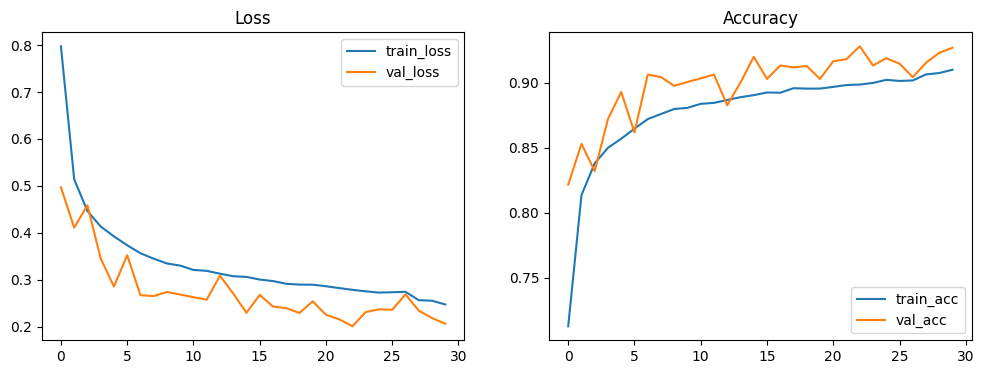

In [14]:
# Plot training curves
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

plot_history(history)


In [15]:
# Load best model & evaluate on test set
best_model_path = os.path.join(output_dir, "best_model.h5")
model = keras.models.load_model(best_model_path)

y_test_cat = keras.utils.to_categorical(y_test)
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print("Test accuracy:", test_acc)


313/313 - 12s - 40ms/step - accuracy: 0.9158 - loss: 0.2367
Test accuracy: 0.9157999753952026


313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.84      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.87      0.88      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.79      0.76      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.99      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



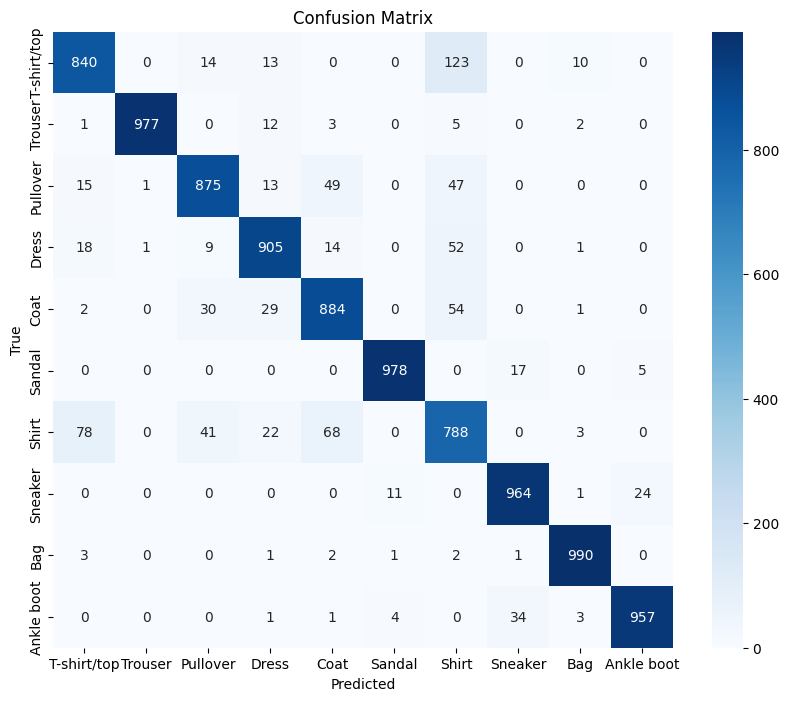

In [16]:
# Confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred, target_names=class_names))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Confusion Matrix')
plt.show()


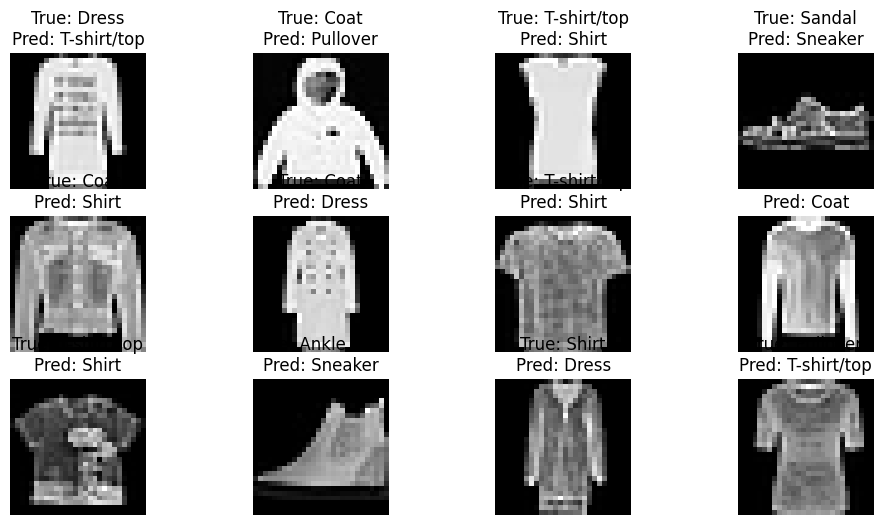

In [17]:
# Show example correct / incorrect predictions
def show_examples(x, y_true, y_pred, class_names, correct=True, n=12):
    idxs = np.where((y_true == y_pred) == correct)[0]
    np.random.shuffle(idxs)
    idxs = idxs[:n]
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(idxs):
        plt.subplot(3,4,i+1)
        plt.imshow(x[idx].squeeze(), cmap='gray')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
        plt.axis('off')
    plt.show()

show_examples(x_test, y_test, y_pred, class_names, correct=False, n=12)


Last conv layer: conv2d_3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


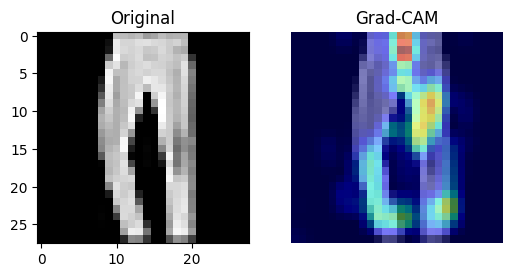

In [18]:
# Grad-CAM (explainability)
import tensorflow as tf
import numpy as np
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print("Last conv layer:", last_conv_layer_name)

idx = 5
img = x_test[idx]
img_input = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
heatmap_resized = cv2.resize(heatmap, (28,28))
heatmap_colored = (heatmap_resized * 255).astype("uint8")

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img.squeeze(), cmap='gray'); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(img.squeeze(), cmap='gray'); plt.imshow(heatmap_resized, cmap='jet', alpha=0.5); plt.title("Grad-CAM")
plt.axis('off')
plt.show()


In [19]:
# Save model artifacts & sample inference function
def predict_single(img_array, model):
    if img_array.ndim == 2:
        img_array = np.expand_dims(img_array, -1)
    img = np.expand_dims(img_array, 0)
    probs = model.predict(img)[0]
    pred_idx = np.argmax(probs)
    return class_names[pred_idx], probs[pred_idx]

sample_img = x_test[0]
label, conf = predict_single(sample_img, model)
print("Predicted:", label, "Confidence:", conf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted: Ankle boot Confidence: 0.9995858


## Notes & Next steps
- Try deeper architectures or transfer learning (resize to 224x224 and use EfficientNet/ResNet).  
- Use K-Fold CV for robust estimates.  
- Combine image model outputs with metadata (price, season) if available for trend prediction.

---

**Created:** 2025-10-18T20:50:09.605019Z
